<a href="https://colab.research.google.com/github/ryosanada/kuzushiji_1/blob/main/sanada/baseline_%E8%87%AA%E4%BD%9Cyolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install --target /content/drive/MyDrive/Colab\ Notebooks/module/ cPickle

In [86]:
import numpy as np
import io
from PIL import Image
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from pathlib import Path
import cv2
import os
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import torch


import warnings
warnings.filterwarnings(action="ignore")

In [24]:
# path
path_train_1 = '/content/drive/MyDrive/Colab Notebooks/SIGNATE/くずし字認識チャレンジ①/data/train_1.zip'
path_train_2 = '/content/drive/MyDrive/Colab Notebooks/SIGNATE/くずし字認識チャレンジ①/data/train_2.zip'
path_train_3 = '/content/drive/MyDrive/Colab Notebooks/SIGNATE/くずし字認識チャレンジ①/data/train_3.zip'
path_train_4 = '/content/drive/MyDrive/Colab Notebooks/SIGNATE/くずし字認識チャレンジ①/data/train_4.zip'

#image_size
img_size = 416

## dataset作成

In [113]:
img_list = []
img_dict = {'name': [], 'width': [], 'height': []}
annot_list = []
annot_dict = {'name': [], 'centroid_x': [], 'centroid_y': [], 'width': [], 'height': []}

with zipfile.ZipFile(path_train_4, 'r') as zip_file:
    # zipファイル内の各ファイルについてループ
    for info in tqdm(zip_file.infolist()):
        # 画像ファイル
        if info.filename.endswith('.jpg'):
            img_list.append(info.filename)
            img_dict['name'].append(info.filename[:-4])
            # 対象の画像ファイルを開く
            with zip_file.open(info.filename) as img_file:
                # 画像のバイナリデータを読み込む
                img_bin = io.BytesIO(img_file.read())
                # バイナリデータをpillowから開く
                img = Image.open(img_bin)
                # size
                img_dict['width'].append(img.size[0])
                img_dict['height'].append(img.size[1])

        # tsvファイル
        elif info.filename.endswith('.tsv'):
            annot_list.append(info.filename)
            # 対象のtsvファイルを開く
            with zip_file.open(info.filename) as annot_file:
                annots = np.loadtxt(annot_file, delimiter="\t")
                if np.ndim(annots) == 1:
                    annots = annots[np.newaxis]
                for a in annots:   
                    annot_dict['name'].append(info.filename[:-4])
                    x_list = a[0::2]
                    y_list = a[1::2]
                    centroid_x = np.mean(x_list)
                    centroid_y = np.mean(y_list)
                    width = np.max(x_list) - np.min(x_list)
                    height = np.max(y_list) - np.min(y_list)
                    annot_dict['centroid_x'].append(centroid_x)
                    annot_dict['centroid_y'].append(centroid_y)
                    annot_dict['width'].append(width)
                    annot_dict['height'].append(height)

df_annot = pd.DataFrame(annot_dict)
df_img = pd.DataFrame(img_dict)

df_tmp = pd.merge(df_annot, df_img, how='inner', on='name', suffixes=('_annot', '_img'))
df_annot = df_tmp[['name']]
df_annot['label'] = 0
df_annot[['centroid_x', 'centroid_y']] = df_tmp[['centroid_x', 'centroid_y']].values /  df_tmp[['width_img', 'height_img']].values * img_size
df_annot[['width', 'height']] = df_tmp[['width_annot', 'height_annot']].values /  df_tmp[['width_img', 'height_img']].values * img_size
df_annot.head()

100%|██████████| 90/90 [00:00<00:00, 128.22it/s]


,name,label,centroid_x,centroid_y,width,height
0,train/041/000000,0,396.160000,206.012739,37.120000,399.946047
1,train/041/000000,0,358.133333,205.467216,34.773333,398.231547
2,train/041/000000,0,318.186667,204.454103,32.640000,398.075684
3,train/041/000000,0,282.933333,204.376171,30.720000,397.608093
4,train/041/000000,0,244.053333,205.116523,29.440000,399.322593


In [114]:
km = KMeans(n_clusters=9,            
            init='random',         
            n_init=10,              
            max_iter=300,            
            tol=1e-04,               
            random_state=0)          
y_km = km.fit_predict(df_annot[['width', 'height']])

df_annot['cluster'] = y_km
df_annot.head()

,name,label,centroid_x,centroid_y,width,height,cluster
0,train/041/000000,0,396.160000,206.012739,37.120000,399.946047,8
1,train/041/000000,0,358.133333,205.467216,34.773333,398.231547,8
2,train/041/000000,0,318.186667,204.454103,32.640000,398.075684,8
3,train/041/000000,0,282.933333,204.376171,30.720000,397.608093,8
4,train/041/000000,0,244.053333,205.116523,29.440000,399.322593,8


In [115]:
df_annot.cluster.value_counts().sort_index()

0    70
1    13
2    21
3    24
4    39
5    82
6    11
7    94
8    93
Name: cluster, dtype: int64

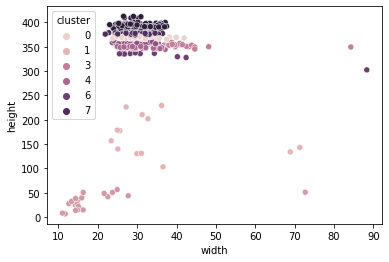

In [116]:
sns.scatterplot(data=df_annot, x='width', y='height', hue='cluster')

In [117]:
anchor_dict = {"width":[],"height":[],"area":[]}
for i in range(9):
    anchor_dict["width"].append(df_annot[df_annot["cluster"] == i].mean()["width"])
    anchor_dict["height"].append(df_annot[df_annot["cluster"] == i].mean()["height"])
    anchor_dict["area"].append(df_annot[df_annot["cluster"] == i].mean()["width"]*df_annot[df_annot["cluster"] == i].mean()["height"])
  

anchor = pd.DataFrame(anchor_dict).sort_values('area', ascending=False)
anchor["type"] = [int(img_size/32) ,int(img_size/32) ,int(img_size/32) ,  int(img_size/16) ,int(img_size/16) ,int(img_size/16) , int(img_size/8), int(img_size/8), int(img_size/8)]
print(anchor)

       width      height          area  type
3  42.224763  353.230338  14915.067301    13
6  36.268151  331.847064  12035.479360    13
8  29.336668  395.665882  11607.518437    13
7  29.385297  377.513843  11093.356429    26
0  29.668828  367.614862  10906.701942    26
4  30.544855  348.510532  10645.203540    26
5  28.959186  358.563841  10383.717013    52
1  35.698652  166.386760   5939.783136    52
2  19.440848   31.612808    614.579798    52


In [125]:
np.squeeze(df_annot[:1][['label', 'centroid_x', 'centroid_y', 'width', 'height']].values).tolist()

[0.0, 396.15999999999997, 206.01273885350318, 37.12, 399.9460472086924]

In [176]:
from six import b
from torch.utils.data import Dataset,DataLoader
import cv2
from PIL import Image
import math
import numpy as np
from torchvision.ops.boxes import box_iou

class YOLOv3_Dataset(Dataset):
    def __init__(self,zip_path, img_list, annot_list, df_annot,class_n,img_size,anchor_dict,transform):
        super().__init__()
        self.zip_path = zip_path
        self.img_list = img_list
        self.label_list = annot_list
        self.df_annot = df_annot
        self.anchor_dict = anchor_dict
        self.class_n = class_n
        self.img_size = img_size
        self.transform = transform
        self.anchor_iou = torch.cat([torch.zeros(9,2) , torch.tensor(self.anchor_dict[["width","height"]].values)] ,dim = 1)  

    def get_label(self , path):
        bbox_list = []
        annots = df_annot[df_annot.name == path[:-4]][['label', 'centroid_x', 'centroid_y', 'width', 'height']]
        for a in annots.values:
            bbox = np.squeeze(a).tolist()
            bbox_list.append(bbox)
        return bbox_list  
    
    def get_img(self, path):
        with zipfile.ZipFile(self.zip_path) as zip_file:
            with zip_file.open(path) as img_file:
                # 画像のバイナリデータを読み込む
                img_bin = io.BytesIO(img_file.read())
                # バイナリデータをpillowから開く
                img = Image.open(img_bin)
        return img.resize((img_size, img_size), Image.LANCZOS)

    def wh2twth(self, wh):
        twth = []
        for i in range(9):
          anchor = self.anchor_dict.iloc[i]
          aw = anchor["width"]
          ah = anchor["height"]
          twth.append([math.log(wh[0]/aw) , math.log(wh[1]/ah)])
        return twth   

    def cxcy2txty(self,cxcy):
        map_size = [int(self.img_size/32) , int(self.img_size/16) , int(self.img_size/8)]
        txty = []
        for size in map_size:
          grid_x = int(cxcy[0]*size)
          grid_y = int(cxcy[1]*size)    
          tx = math.log((cxcy[0]*size - grid_x + 1e-10) / (1 - cxcy[0]*size +grid_x+ 1e-10))
          ty = math.log((cxcy[1]*size - grid_y+ 1e-10) / (1 - cxcy[1]*size + grid_y+ 1e-10))
          txty.append([grid_x , tx , grid_y ,ty])
        return txty  

    def label2tensor(self , bbox_list):
        map_size = [int(self.img_size/32) , int(self.img_size/16) , int(self.img_size/8)]
        tensor_list = []  
        for size in map_size:
          for x in range(3):
            tensor_list.append(torch.zeros((4 + 1 + self.class_n,size,size)))

        for bbox in bbox_list:
          cls_n = int(bbox[0])
          txty_list = self.cxcy2txty(bbox[1:3])
          twth_list = self.wh2twth(bbox[3:])
          label_iou = torch.cat([torch.zeros((1,2))  , torch.tensor(bbox[3:]).unsqueeze(0)],dim=1)
          iou = box_iou(label_iou, self.anchor_iou)[0]
          obj_idx = torch.argmax(iou).item()
          for i , twth in enumerate(twth_list):
            tensor = tensor_list[i]
            txty = txty_list[int(i/3)]

            if i == obj_idx:
            
              tensor[0,txty[2],txty[0]] = txty[1]
              tensor[1,txty[2],txty[0]] = txty[3]
              tensor[2,txty[2],txty[0]] = twth[0]
              tensor[3,txty[2],txty[0]] = twth[1]
              tensor[4,txty[2],txty[0]] = 1
              tensor[5 + cls_n,txty[2],txty[0]] = 1

        scale3_label = torch.cat(tensor_list[0:3] , dim = 0)
        scale2_label = torch.cat(tensor_list[3:6] , dim = 0)
        scale1_label = torch.cat(tensor_list[6:] , dim = 0)  

        return scale3_label , scale2_label , scale1_label  
    

    def __getitem__(self , idx):
        img_path = self.img_list[idx]

        label_path = self.label_list[idx]

        bbox_list = self.get_label(label_path)
        img = self.get_img(img_path)
        img = self.transform(img)
        scale3_label , scale2_label , scale1_label = self.label2tensor(bbox_list)

        return img , scale3_label , scale2_label , scale1_label
    
    def __len__(self):
        return len(self.img_list)

In [177]:
import torchvision.transforms as T
transform = T.Compose([T.ToTensor()])
train_4_dataset = YOLOv3_Dataset(path_train_4, img_list, annot_list, df_annot, 1, img_size, anchor, transform)

In [178]:
train_4_dataset[0]

IndexError: ignored

In [154]:
img_list[0]

'train/041/000000.jpg'

In [155]:
annot_list[0]

'train/041/000000.tsv'

In [158]:
df_annot[df_annot['name'] == img_list[0][:-4]]

,name,label,centroid_x,centroid_y,width,height,cluster
0,train/041/000000,0,396.160000,206.012739,37.120000,399.946047,8
1,train/041/000000,0,358.133333,205.467216,34.773333,398.231547,8
2,train/041/000000,0,318.186667,204.454103,32.640000,398.075684,8
3,train/041/000000,0,282.933333,204.376171,30.720000,397.608093,8
4,train/041/000000,0,244.053333,205.116523,29.440000,399.322593,8
5,train/041/000000,0,205.653333,203.791682,26.666667,397.919820,8
6,train/041/000000,0,167.893333,211.312102,27.520000,384.671413,7
7,train/041/000000,0,131.360000,204.571000,34.773333,398.543275,8
8,train/041/000000,0,92.320000,203.518921,36.053333,398.387411,8
9,train/041/000000,0,53.813333,203.440989,35.626667,396.984638,8


In [ ]:
import numpy as np

def visualization(y_pred,anchor,img_size,conf = 0.5,is_label = False):
  size = y_pred.shape[2]
  print('size', size)
  anchor_size = anchor[anchor["type"] == size]
  print('anchor_size', anchor_size)
  bbox_list = []
  for i in range(3):
    a = anchor_size.iloc[i]
    print('a', a)
    grid = img_size/size
    y_pred_cut = y_pred[0,i*(4 + 1 + class_n) :(i+1)*(4 + 1 + class_n) ].cpu()
    print('y_pred_cut', y_pred_cut)
    if is_label:
      y_pred_conf = y_pred_cut[4,:,:].cpu().numpy()
    else:
      y_pred_conf = torch.sigmoid(y_pred_cut[4,:,:]).cpu().numpy()         
    index = np.where(y_pred_conf > conf)
    print('index', index)
    
    
    for y,x in zip(index[0],index[1]):
      cx = x*grid + torch.sigmoid(y_pred_cut[0,y,x]).numpy()*grid
      cy = y*grid + torch.sigmoid(y_pred_cut[1,y,x]).numpy()*grid
      width = a["width"]*torch.exp(y_pred_cut[2,y,x]).numpy()*img_size
      height = a["height"]*torch.exp(y_pred_cut[3,y,x]).numpy()*img_size
      xmin,ymin,xmax,ymax = cx - width/2 , cy - height/2 ,cx + width/2 , cy + height/2
      bbox_list.append([xmin,ymin,xmax,ymax])
  return bbox_list
 
import torchvision.transforms.functional as FF
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = FF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
img_list = glob.glob(os.path.join(images_path,"*"))
img_size = 416

print(anchor)
import torchvision.transforms as T
class_n = 1
img_list = sorted(glob.glob(os.path.join(images_path,"*")))
label_list = sorted(glob.glob(os.path.join(label_path,"*")))
transform = T.Compose([T.ToTensor()])
train_data = YOLOv3_Dataset(img_list,label_list,80,img_size , anchor,transform)
train_loader = DataLoader(train_data , batch_size = 1)

for n , (img , scale3_label , scale2_label ,scale1_label) in enumerate(train_loader):
  path = img_list[n]
  img = cv2.imread(path)[:,:,::-1]
  img = cv2.resize(img , (img_size , img_size))
  img = torch.tensor(img.transpose(2,0,1))
  preds = [scale3_label , scale2_label , scale1_label]
  for color,pred in zip(["red","green","blue"],preds):
    bbox_list = visualization(pred,anchor,img_size,conf = 0.9,is_label = True)
    img = draw_bounding_boxes(img, torch.tensor(bbox_list), colors=color, width=1)
  show(img)

In [28]:
class train_data_load:
    def __init__(self, path):
        self.img_data, self.annot_data, self.filename_list = self.import_from_zip(path)

    def import_from_zip(self, zip_path):
        print('import from : ', zip_path)
        # 配列格納用のList
        img_data = []
        img_filename = []
        annot_data = []
        annot_filename = []

        # zipの読み込み
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            # zipファイル内の各ファイルについてループ
            for info in tqdm(zip_file.infolist()):
                # 画像ファイルの場合
                if info.filename.endswith('.jpg'):
                    img_filename.append(info.filename[:-4])
                    # 対象の画像ファイルを開く
                    with zip_file.open(info.filename) as img_file:
                        # 画像のバイナリデータを読み込む
                        img_bin = io.BytesIO(img_file.read())
                        # バイナリデータをpillowから開く
                        img = Image.open(img_bin)
                        # 画像データを配列化
                        img_array = np.array(img)
                        # 格納用のListに追加
                        img_data.append(img_array)

                # アノテーションファイルの場合
                if info.filename.endswith('.tsv'):
                    annot_filename.append(info.filename[:-4])
                    # 対象の画像ファイルを開く
                    with zip_file.open(info.filename) as annot_file:
                        annot = np.loadtxt(annot_file, delimiter="\t")
                        if np.ndim(annot) == 1:
                            annot = annot[np.newaxis]
                        elif np.ndim(annot) != 2:
                            raise Exception(f"""
                            アノテーションファイルに不備があります。
                            filename : {info.filename}
                            """)
                        annot_data.append(annot)

        # filenameが順番通りか確認
        if img_filename != annot_filename:
            raise Exception("filenameが順番通りじゃない")

    	# 処理が完了後、np.arrayに変換
        return np.array(img_data), np.array(annot_data), np.array(img_filename)

    def plot(self, slice=None, size=5):
        if slice == None:
            s0, s1 = 0, self.img_data.shape[0]
        else:
            s0, s1 = slice[0], slice[1]
        len = s1 - s0
        images = self.img_data[s0:s1]
        annots = self.annot_data[s0:s1]
        filenames = self.filename_list[s0:s1]

        row = (np.ceil(len / 5)).astype(int)
        col = (np.min([len, 5])).astype(int)
        fig, axes = plt.subplots(row, col, figsize=(size * col, size * row))

        for i in tqdm(range(len)):
            ax = axes.ravel()[i]
            ax.set_title(filenames[i])
            ax.imshow(images[i])
            for x1, y1, x2, y2, x3, y3, x4, y4 in annots[i]:
                ax.plot([x1, x2], [y1, y2], color="red")
                ax.plot([x2, x3], [y2, y3], color="red")
                ax.plot([x3, x4], [y3, y4], color="red")
                ax.plot([x4, x1], [y4, y1], color="red")

            ax.axis('off')
        plt.show()



In [29]:
# train_1 = train_data_load(path_train_1)
# train_2 = train_data_load(path_train_2)
# train_3 = train_data_load(path_train_3)
train_4 = train_data_load(path_train_4)

import from :  /content/drive/MyDrive/Colab Notebooks/SIGNATE/くずし字認識チャレンジ①/data/train_4.zip


100%|██████████| 90/90 [00:06<00:00, 13.68it/s]


In [30]:
for d in train_4.img_data[:5]:
    print(d.shape)

(2669, 1950, 3)
(2826, 1977, 3)
(2703, 1937, 3)
(3039, 1874, 3)
(2713, 1973, 3)


100%|██████████| 5/5 [00:00<00:00,  9.39it/s]


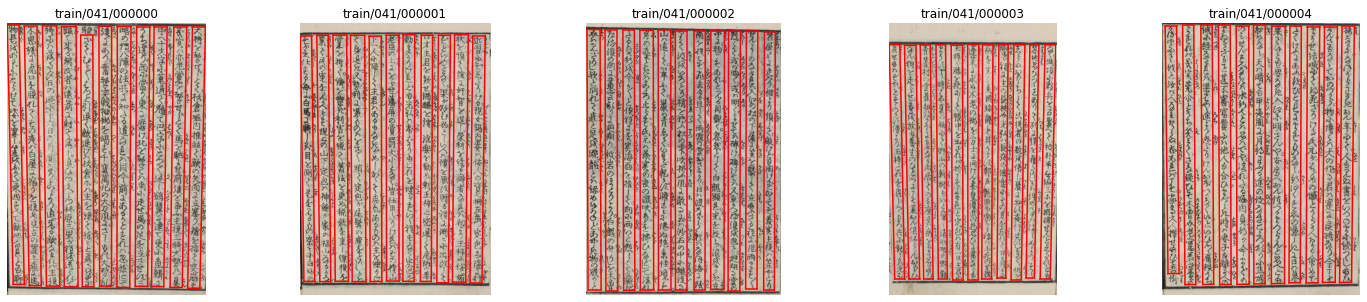

In [ ]:
train_4.plot((0,5))

## 評価指標

### IoU

In [ ]:
train_4.annot_data[0][0]

array([1819.,   39., 1772., 2604., 1891., 2605., 1946.,   39.])

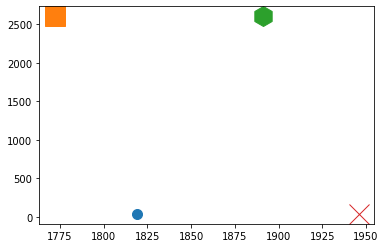

In [ ]:
plt.plot(train_4.annot_data[0][0][0], train_4.annot_data[0][0][1], marker='.', markersize=20)
plt.plot(train_4.annot_data[0][0][2], train_4.annot_data[0][0][3], marker='s', markersize=20)
plt.plot(train_4.annot_data[0][0][4], train_4.annot_data[0][0][5], marker='h', markersize=20)
plt.plot(train_4.annot_data[0][0][6], train_4.annot_data[0][0][7], marker='x', markersize=20)

plt.show()

In [ ]:
train_4.annot_data[0]

array([[1819.,   39., 1772., 2604., 1891., 2605., 1946.,   39.],
       [1636.,   41., 1599., 2595., 1718., 2596., 1762.,   41.],
       [1442.,   35., 1417., 2588., 1537., 2589., 1570.,   35.],
       [1271.,   36., 1256., 2586., 1378., 2587., 1400.,   36.],
       [1081.,   36., 1077., 2596., 1203., 2597., 1215.,   35.],
       [ 900.,   32.,  907., 2583., 1024., 2584., 1025.,   31.],
       [ 721.,  122.,  737., 2589.,  850., 2590.,  840.,  122.],
       [ 532.,   35.,  560., 2590.,  695., 2591.,  676.,   34.],
       [ 346.,   29.,  385., 2582.,  515., 2584.,  485.,   28.],
       [ 167.,   32.,  216., 2578.,  334., 2579.,  292.,   32.],
       [   0.,   23.,   59., 2566.,  167., 2567.,  115.,   23.]])

## OpenCV

In [ ]:
img = train_4.img_data[0]

In [ ]:
# convert image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# grayscale image represented as a 2-d array
print(gray_img)

[[114  98  93 ... 200 201 200]
 [ 89  74  71 ... 202 202 202]
 [ 87  75  74 ... 201 201 200]
 ...
 [200 203 198 ... 186 188 190]
 [201 204 198 ... 187 190 193]
 [201 204 199 ... 188 190 192]]


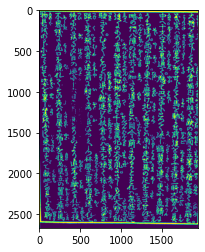

In [ ]:
# get binary image and apply Gaussian blur
# coins = cv2.imread('images/coins.jpg')
coins_gray = gray_img
coins_preprocessed = cv2.GaussianBlur(coins_gray, (5, 5), 0)

# get binary image
_, coins_binary = cv2.threshold(coins_preprocessed, 130, 255, cv2.THRESH_BINARY)

# invert image to get coins
coins_binary = cv2.bitwise_not(coins_binary)
plt.imshow(coins_binary)

In [ ]:
# find contours
coins_contours, _ = cv2.findContours(coins_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# make copy of image
coins_and_contours = np.copy(img)

# find contours of large enough area
min_coin_area = 60
large_contours = [cnt for cnt in coins_contours if cv2.contourArea(cnt) > min_coin_area]

# draw contours
cv2.drawContours(coins_and_contours, large_contours, -1, (255,0,0))

# print number of contours
print('number of coins: %d' % len(large_contours))

number of coins: 791


In [ ]:
# create copy of image to draw bounding boxes
bounding_img = np.copy(img)

# for each contour find bounding box and draw rectangle
for contour in large_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(bounding_img, (x, y), (x + w, y + h), (0, 255, 0), 3)

# plt.figure(figsize=(8,8))
# plt.imshow(a)

## YOLOのダウンロード

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 13325, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 13325 (delta 29), reused 21 (delta 13), pack-reused 13286
Receiving objects: 100% (13325/13325), 12.00 MiB | 27.00 MiB/s, done.
Resolving deltas: 100% (9283/9283), done.


In [ ]:
# with open(path_pickle_train_1, 'wb') as p:
#     pickle.dump(train_1, p)

# with open(path_pickle_train_2, 'wb') as p:
#     pickle.dump(train_2, p)

# with open(path_pickle_train_3, 'wb') as p:
#     pickle.dump(train_3, p)
    
with open(path_obj_train_4, 'wb') as p:
    joblib.dump(train_4, p, compress=3)
